# Midterm

## File Locations

In [1]:
ATHLETES = './data/athletes.csv'
MOVIES = './data/movies.csv'

## Part 1

#### Question 1: What is the difference between SparkContext and SparkSession?
SparkContext is the entry point for unstructured API for using Spark whereas SparkSession is a wrapper over SparkContext.

*SparkContext* is a connection to the Spark cluster and it runs on the master node. It allows you to work with the worker nodes using a resource manager.

*SparkSession* uses DataFrames and Datasets to make it more convenient to work with Spark. SparkSession contains a SparkContext making it possible to work with all the underlying Spark functionality via SparkContext.

#### Question 2: Explain the shuffle operation in Spark operations. Give an example.

The shuffle operation is the term given to Spark's operation to redistribute the input data so that it is grouped differently across partitions. This is done because the results of an operation may not reside in the same partition.

For example in the `reduceByKey` operation, tuples of `(key, result)` pairs are generated and there can be more than one result for a key. However, the results for a single key could be located across multiple partitions, so Spark has to read all the data across all the partitions to ensure that the results for each key are correct. This operation is called the *shuffle*.

#### Question 3: What is the difference between a Spark transformation and a Spark action?
A *Spark Transformation* is a series of operations that would work on the input data and transform it, giving the result in a Dataset (RDD). However, this is lazy, meaning that this series of operations are not applied till an action is run.

Examples of transformations include:
* map
* filter
* sample
* union
* distinct
* groupByKey
* repartition

A *Spark Action* causes a transformation to be executed. This gets the result of the transformation and returns it to the driver program.

Examples of actions include:
* reduce
* collect
* count
* first
* take

#### Question 4: Cleaning Data
##### a. What operations do we have on Panda DataFrames to deal with missing values?
* `isna()` and `notna()` find missing values in DataFrames.
* `fillna()` can fill missing values by copying the previous or next non-NA value.
* `dropna()` will drop rows with missing values.
* `interpolate()` will apply linear interpolation to guess missing values

##### b. What are some of the problems that occur in dealing with missing values in Panda DataFrames?
* If you do not remove missing values or didn't remove all of them, pandas has default behaviour with missing values in its arithmetic operations.
* This can lead to some inconsistencies. For example, if you add all NaN values, you get 0 but if you multiply all NaN values you get 1.
* If you use cumulative methods then NaN values will be ignored, but they will still be present in the resulting arrays by default.

##### c. What operations do we have on Spark DataFrames to deal with missing values?
In Spark we can set the fields to either be nullable or not. We can then filter out values that are null using `isnotnull()`. We can also create User Defined Functions to provide our own logic to handle null values and missing data.

#### Question 5: What is a categorical variable? Give an example.
Categorical variables are *qualitative* variables, ones which have labels or names as values.

For example, if we're trying to classify a shape then the categorical variables could be the names like triangle, square, pentagon, hexagon, etc.

#### Question 6: What are hyperparameters? Give an example.
Hyperparameters are variables used to tune models. These parameters will change how a model behaves for the same set of input data.

An example is for K-Means clustering, the number of clusters is a hyperparameter.

## Imports

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.cluster
import sklearn.naive_bayes
import sklearn.metrics
import sklearn.decomposition


## Function Declarations

In [3]:
sns.set(palette='Set1')
DPI = 200

def plot_large():
    plt.figure(figsize=(8, 5), dpi=DPI)
    
def plot_small():
    plt.figure(figsize=(3.5, 2), dpi=DPI)

## Part Two: Athletes
### Reading the dataset

In [4]:
athletes_df = pd.read_csv(ATHLETES)
athletes_df.head()

,Name,Country,Age,"Height, cm",Weight,Sex,Date of birth,Place of birth,Gold,Silver,Bronze,Total,Sport,Event
0,Lamusi A,People's Republic of China,23,170.0,60.0,M,6/2/1989,NEIMONGGOL (CHN),0,0,0,0,Judo,Men's -60kg
1,A G Kruger,United States of America,33,193.0,125.0,M,2/18/1979,Sheldon (USA),0,0,0,0,Athletics,Men's Hammer Throw
2,Jamale Aarrass,France,30,187.0,76.0,M,11/15/1981,BEZONS (FRA),0,0,0,0,Athletics,Men's 1500m
3,Abdelhak Aatakni,Morocco,24,NaN,NaN,M,2/9/1988,AIN SEBAA (MAR),0,0,0,0,Boxing,Men's Light Welter (64kg)
4,Maria Abakumova,Russian Federation,26,178.0,85.0,F,1/15/1986,STAVROPOL REGION (RUS),0,0,0,0,Athletics,Women's Javelin Throw


### Problem 1: Cleaning the data
We first want to find out how many missing values are there. The following queries will tell us.

In [5]:
df = athletes_df[athletes_df.isna().any(axis=1)]
missing_percent = len(df) * 100 / len(athletes_df)
print("Total number of rows: {}".format(len(athletes_df)))
print("Percentage of missing data: {}%".format(missing_percent))

Total number of rows: 10384
Percentage of missing data: 37.384437596302%


More than a third of the data has missing values in at least one column. We cannot simply remove all the rows which have missing values, because we may be throwing out rows where the data is missing in columns that we're not interested in. Instead, as we know what columns we're interested in, we can only remove rows with data missing in the columns we're interested in:
* Height, cm
* Weight
* Sex
* Total
* Sport
* Country

Now we check how many rows have missing data in only these columns.

In [ ]:
columns = ['Height, cm', 'Weight', 'Sex', 'Total', 'Sport', 'Country']
athletes_clean_df = athletes_df.dropna(subset=columns)
missing_percent = (len(athletes_df) - len(athletes_clean_df)) * 100 / len(athletes_df)
print("Total number of rows: {}".format(len(athletes_df)))
print("Percentage of missing data: {}%".format(missing_percent))

Total number of rows: 10384
Percentage of missing data: 12.962249614791988%



Instead of over a third of the data being dropped, we're only dropping just under 13% of the data. Though still a significant amount of data, it's a lot less data that we'll be dropping than before.

We'll therefore be working with `athletes_clean_df` for the rest of **Part Two**.

### Problem 2: Scatter Plot of athletes' weight vs height

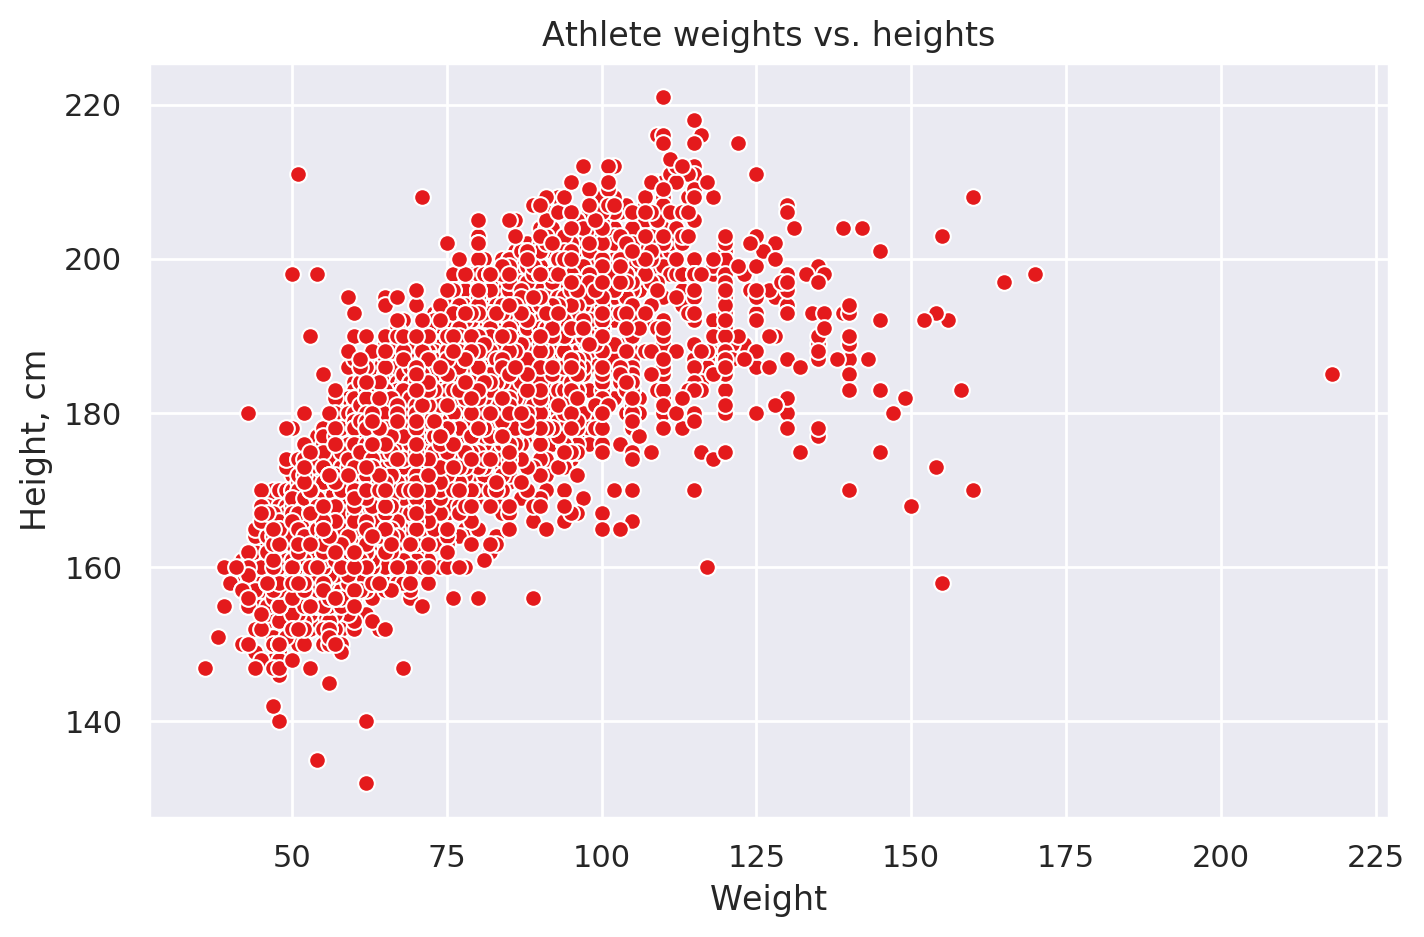

In [ ]:
plot_large()
sns.scatterplot(x='Weight', y='Height, cm', data=athletes_clean_df)
plt.title('Athlete weights vs. heights');

### Problem 3: Box Plots

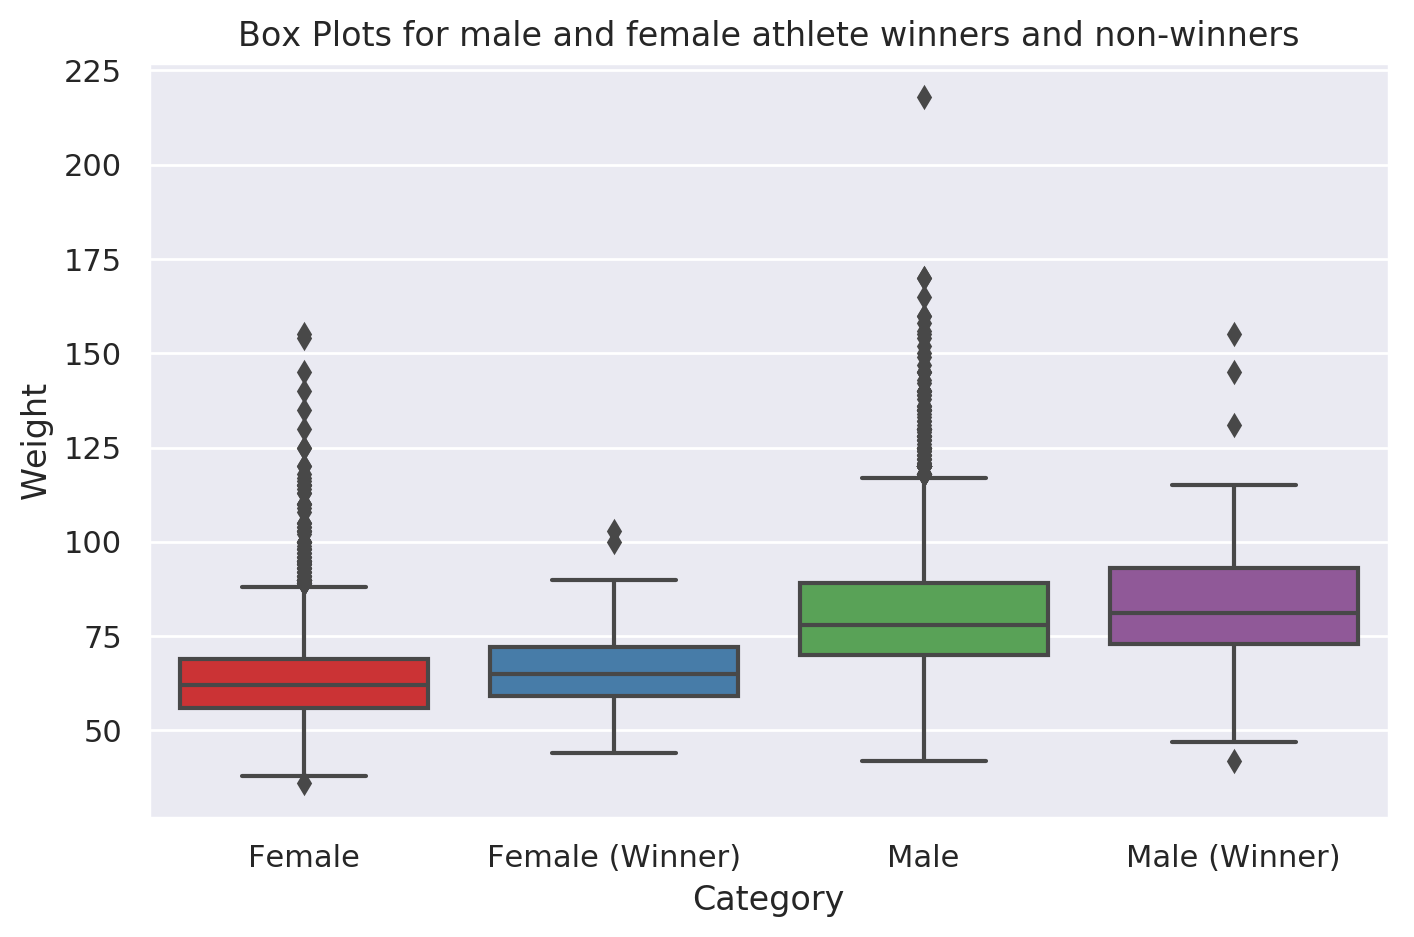

In [ ]:
plot_large()

winners_dict = {}
winners_dict['Male'] = athletes_clean_df[athletes_clean_df.Sex == 'M']['Weight']
winners_dict['Female'] = athletes_clean_df[athletes_clean_df.Sex == 'F']['Weight']
winners_dict['Male (Winner)'] = athletes_clean_df[(athletes_clean_df.Sex == 'M')
                                                  & (athletes_clean_df.Total > 0)]['Weight']
winners_dict['Female (Winner)'] = athletes_clean_df[(athletes_clean_df.Sex == 'F')
                                                    & (athletes_clean_df.Total > 0)]['Weight']

winners_df = pd.melt(pd.DataFrame(winners_dict), var_name='Category', value_name='Weight')

sns.boxplot(x='Category', y='Weight', data=winners_df.sort_values(by='Category'))
plt.title('Box Plots for male and female athlete winners and non-winners');

#### Comments
* In both categories, the winners' weight range is slightly higher than the non-winners' weight range.
* We can see in general that there are a lot of outliers for non-winners in male & female categories, but a lot less in winners. This gives a very good indication that there is an ideal weight range that you would want to be in.
* Female athletes have a lower weight range than male athletes.

### Problem 4: Swarm Plots of athlete ages and weights

In [ ]:
plot_large()

winners_dict = {}
winners_dict['Male (Winner)'] = athletes_clean_df[(athletes_clean_df.Sex == 'M')
                                                  & (athletes_clean_df.Total > 0)]['Age']
winners_dict['Female (Winner)'] = athletes_clean_df[(athletes_clean_df.Sex == 'F')
                                                    & (athletes_clean_df.Total > 0)]['Age']

winners_df = pd.melt(pd.DataFrame(winners_dict), var_name='Category', value_name='Age')

sns.swarmplot(x='Category', y='Age', data=winners_df, palette="Paired")
plt.title('Swarm Plots of Athlete Ages and Weights');

#### Comments
* Most winners are concentrated in a particular age range of around 20 to 33 years, with some outliers.
* Female winners tend to be younger than male winners.

### Problem 5: Violin Plots for Archery, Sailing, and Swimming

In [ ]:
sports = ['Archery', 'Sailing', 'Swimming']
plot_large()
sns.violinplot(x='Sport', y='Age', data=athletes_clean_df[athletes_clean_df.Sport.isin(sports)])
plt.title('Age Distribution per Sport');

#### Comments
* Archery has the widest range of ages, Swimming has the shortest range and Sailing's age range falls between the two.
* The average Swimming age is the youngest, followed closely by Archery and then by Sailing.
* The tapering edges at the top of each plot shows older athletes; Swimming has the least number of old athletes, Sailing has a moderate amount and Archery has the most out of the 3 sports.

### Problem 6: Histogram of Medals per Country
We need to format the data in order to plot it:
1. Group the data by countries, taking the total of all its rows and arranging them in descending order of total medals
1. Drop the countries which have no medals, otherwise we have too many countries to plot which are adding no data to the graph
1. Remove unneeded columns
1. Plot the histogram

In [ ]:
# 1
grouped_df = athletes_clean_df.groupby(['Country']).sum().reset_index().sort_values(by=['Total'], ascending=False)
# 2
grouped_df = grouped_df[grouped_df.Total > 0]
# 3
columns_to_keep = ['Country', 'Gold', 'Silver', 'Bronze']
grouped_df = pd.melt(grouped_df[columns_to_keep], id_vars="Country", var_name="Medal", value_name="Count")
# 4
plot_large()
medal_palette = ['#D9A441', '#A8A8A8', '#965A38']
sns.barplot(x='Country', y='Count', hue='Medal', data=grouped_df, palette=medal_palette)
plt.xticks(rotation=90);

If we skip step 3 we can get a bar graph of total medals won per country.

In [ ]:
# 1
grouped_df = athletes_clean_df.groupby(['Country']).sum().reset_index().sort_values(by=['Total'], ascending=False)
# 2
grouped_df = grouped_df[grouped_df.Total > 0]
# 4
plot_large()
sns.barplot(x='Country', y='Total', data=grouped_df, palette="RdYlBu")
plt.ylabel('Total medals won')
plt.xticks(rotation=90);

## Part Three: Movies

### Reading the dataset

In [ ]:
movies_df = pd.read_csv(MOVIES)
movies_df.head()

### Class & Function Definitions

#### Functions to create models

In [ ]:
def create_kmeans_model(X, n_clusters, random_state=50):
    kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans.fit(X)
    return kmeans

def create_dbscan_model(X, eps=5, min_samples=2):
    dbscan = sklearn.cluster.DBSCAN(eps=eps, min_samples=min_samples)
    dbscan.fit(X)
    return dbscan

def create_bayes_model(X, y):
    bayes = sklearn.naive_bayes.GaussianNB()
    bayes.fit(X, y)
    return bayes

#### Functions to calculate statistics for models

In [ ]:
class ModelStatistics:
    def __init__(self, stats_dict, confusion, labels):
        self.stats_dict = stats_dict
        self.confusion = confusion
        self.labels = labels

def calculate_bayes_stats(bayes, X, y, labels):
    bayes_accuracy = bayes.score(X, y) * 100
    y_pred = bayes.predict(X)
    return ModelStatistics({'Accuracy': bayes_accuracy},
                           sklearn.metrics.confusion_matrix(y, y_pred),
                           labels)

def create_cluster_to_label_dict(model, y_train, labels):
    cluster_to_label_dict = {}

    for cluster in range(len(labels)):
        label = y_train[model.labels_ == cluster].value_counts().index[0]
        cluster_to_label_dict[cluster] = label

    return cluster_to_label_dict

def calculate_cluster_statistics(X, y_true, y_pred, cluster_to_label_dict):
    num_correct = 0
    for pred_label, true_label in zip(y_pred, y_true):
        if ((pred_label in range(len(cluster_to_label_dict)))
            and (cluster_to_label_dict[pred_label] == true_label)):
            num_correct += 1

    label_to_cluster_dict = {value: key for (key, value) in cluster_to_label_dict.items()}
    
    for label in label_to_cluster_dict.keys():
        y_true = y_true.replace(label, label_to_cluster_dict[label])

    confusion = sklearn.metrics.confusion_matrix(y_true, y_pred)
    confusion = reduce_confusion_matrix(confusion, len(cluster_to_label_dict))

    stats_dict = {}
    stats_dict['Accuracy'] = num_correct * 100 / len(y_pred)
    stats = list(sklearn.metrics.homogeneity_completeness_v_measure(y_true, y_pred))
    stats_dict['Homogeneity'] = stats[0]
    stats_dict['Completeness'] = stats[1]
    stats_dict['V-Measure'] = stats[2]
    stats_dict['Adjusted Rand Index'] = sklearn.metrics.adjusted_rand_score(y_true, y_pred)
    stats_dict['Silhouette'] = sklearn.metrics.silhouette_score(X, y_pred)
    
    return ModelStatistics(stats_dict, confusion, label_to_cluster_dict.keys())

def reduce_confusion_matrix(confusion, num_to_keep):
    '''DBSCAN can have more than 2 clusters, so this fubction drops all clusters beyond the specified range.
    '''
    (rows, cols) = confusion.shape
    confusion = np.delete(confusion, slice(num_to_keep, rows), 0)
    confusion = np.delete(confusion, slice(num_to_keep, cols), 1)
    return confusion

def create_df_from_stats(stats):
    return pd.DataFrame.from_dict({model: stats.stats_dict for (model, stats) in stats.items()})

#### Plotting functions

In [ ]:
def plot_accuracies(stats_df):
    plot_large()
    sns.barplot(x=stats_df.T.index, y='Accuracy', data=stats_df.T)
    plt.yticks(range(0, 110, 10))
    plt.ylabel('Accuracy (%)')

def plot_confusion_matrix(confusion_matrix, labels, title):
    plot_small()
    sns.heatmap(confusion_matrix, annot=True, xticklabels=labels, yticklabels=labels, cmap='gist_heat')
    plt.title(title)

def plot_confusion_matrix_from_stats(stats):
    for (model, model_stats) in stats.items():
        plot_confusion_matrix(model_stats.confusion, model_stats.labels, model)

### Problem 1: Classifiers
We split data into training and testing sets.

In [ ]:
genres = list(movies_df.Genre.unique())
num_genres = len(genres)

X = movies_df.drop(columns=['Title', 'Genre', 'Year', 'Rating', '# Votes', '# Words'])
y = movies_df.Genre

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=125)
stats = {}

#### a) K-Means
In K-Means, we don't know which cluster corresponds to which label. To calculate that, the cluster which has the highest count of a label is assigned that label. So if cluster 0 has more counts of action movies than romance movies, then cluster 0 is given the 'action' label.

In [ ]:
kmeans = create_kmeans_model(X_train, num_genres, random_state=25)
kmeans_label_dict = create_cluster_to_label_dict(kmeans, y_train, genres)
stats['K-Means'] = calculate_cluster_statistics(X_test, y_test, kmeans.predict(X_test), kmeans_label_dict)

#### b) DBSCAN
DBSCAN does not allow you to set how many clusters to use. It can also have outliers, which are assigned a cluster of -1. In order to ensure that we are able to calculate the required statistics, the following values for epsilon and minimum points have been chosen experimentally via trial and error. To simplify code and guarantee deterministic output, the labels are statically assigned to clusters.

In [ ]:
dbscan = create_dbscan_model(X_train, eps=0.03, min_samples=2)
dbscan_label_dict = {0: 'romance', 1: 'action'}
stats['DBSCAN'] = calculate_cluster_statistics(X_test, y_test, dbscan.fit_predict(X_test), dbscan_label_dict)

#### c) GaussianNB (aka Naive Bayes' Algorithm)

In [ ]:
bayes = create_bayes_model(X_train, y_train)
stats['Bayes'] = calculate_bayes_stats(bayes, X_test, y_test, genres)

### Problem 2: Comparison

In [ ]:
stats_df = create_df_from_stats(stats)

In [ ]:
plot_accuracies(stats_df)

**Note**: For DBSCAN, as there are outliers, they're counted as incorrect classifications. That contributes to the low accuracy.

In [ ]:
plot_confusion_matrix_from_stats(stats)

**Note**: For DBSCAN, as there are outliers, these are not plotted in the confusion matrix.

#### Comparison of models
K-Means and Bayes have the same accuracy, but Bayes is able to classify action movies better than romance movies. K-Means, on the other hand, gives slightly more consistent results. K-Means might be a better model in this case. DBSCAN gives terrible results as there is no way to configure it to classify into a set number of labels/clusters.

### Problem 3: Clustering Metrics

In [ ]:
stats_df

#### Comparison of scores
* Accuracy of K-Means is a lot higher than DBSCAN's.
* Adjusted Rand Score of K-Means is slightly higher than DBSCAN's which tells us that K-Means' clusters are a little more similar to each other than DBSCAN's clusters.
* Completeness of K-Means is a little more than DBSCAN's, so K-Means has more data points (that are members of a given class) as elements of the same cluster.
* Homogeneity of K-Means is more than DBSCAN's, so K-Means has more of its clusters containing only data points which are members of a single class.
* Silhouette for K-Means is higer & is a positive value, so that means K-Means' clusters don't overlap but DBSCAN's clusters overlap slightly.
* V-Measure is the harmonic mean of homogeneity and completeness. K-Means has a higher value as it is more homogeneous and complete than DBSCAN.

### Problem 4: Using PCA
To use PCA, we have to create a PCA object and fit it on the training data. This will readjust the axes to dimensions in the training data. But we do not perform PCA on the test data, as the new axes will not correspond to the axes on which the model was trained on.

#### Problems 1 to 3

In [ ]:
num_components_to_use = 30
pca = sklearn.decomposition.PCA(n_components=num_components_to_use)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
stats_reduced = {}

##### K-Means

In [ ]:
kmeans_reduced = create_kmeans_model(X_train_reduced, num_genres, random_state=100)
kmeans_label_dict_reduced = create_cluster_to_label_dict(kmeans_reduced, y_train, genres)
stats_reduced['K-Means'] = calculate_cluster_statistics(X_test_reduced, y_test,
                                                        kmeans_reduced.predict(X_test_reduced),
                                                        kmeans_label_dict_reduced)

##### DBSCAN

In [ ]:
dbscan_reduced = create_dbscan_model(X_train_reduced, eps=0.02, min_samples=2)
dbscan_label_dict_reduced = {0: 'romance', 1: 'action'}
stats_reduced['DBSCAN'] = calculate_cluster_statistics(X_test_reduced, y_test,
                                                       dbscan_reduced.fit_predict(X_test_reduced),
                                                       dbscan_label_dict_reduced)

##### Bayes

In [ ]:
bayes_reduced = create_bayes_model(X_train_reduced, y_train)
stats_reduced['Bayes'] = calculate_bayes_stats(bayes_reduced, X_test_reduced, y_test, genres)

##### Accuracies and Confusion Matrices

In [ ]:
stats_reduced_df = create_df_from_stats(stats_reduced)
plot_accuracies(stats_reduced_df)

In [ ]:
plot_confusion_matrix_from_stats(stats_reduced)

##### Statistics

In [ ]:
stats_reduced_df

#### a) Comparison of models with PCA vs without PCA
* K-Means has the same accuracy.
* DBSCAN shows a lot of improvement in accuracy.
* Bayes gives slightly better accuracy.
* The silhouette score of both clustering algorithms is improved.
* V-Measure of DBSCAN is slightly worse.
* The rest of the stats are unchanged.

#### b) Percentage Variance Captured

In [ ]:
print("Percentage of variance captured by {} PCA components: {}%"
      .format(num_components_to_use, np.cumsum(pca.explained_variance_ratio_)[-1] * 100))